# Product Reviews Clustering from Topics

Product Reviews are documents that I personally crawled from blogs like The Verge, CNet, PCMagazine and TechRadar. The first problem that I tried to solved with LDA is to label the category of a document in the corpus. For example, Canon PowerShot S100 is a camera but the review doesn't have that information implicit on the document, harder categories like Graphics Cards, Wearables or Mobile Apps are not easy to discover with simple techniques like Means on TF-IDF model of the corpus gave me fairly good results, but KMeans on the probabilities of the topics per document that were generated by LDA outperform this result.

In [1]:
%matplotlib inline

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pyLDAvis
import pyLDAvis.gensim
from nltk.tokenize import RegexpTokenizer
import scipy.sparse
import nltk
import gensim
import logging

In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Dataset

The dataset are 12,881 documents, with no duplicates that are on separate files.
On the first line the title of the review is stored and the rest is the full body of the review.
I wrote a "memory-friendly" class to load each document into memory from disk when the object is being iterated, processing each file with the tokenization and steamming at each call of the iterator.

In [4]:
class Dataset:
    def __init__(self, path):
        self.path = path
        self.files = os.listdir(self.path)
        self.titles = np.empty([len(self)]).astype(np.str)
        self.tokenizer = RegexpTokenizer(r'\w+')
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.stemmer = nltk.stem.PorterStemmer()
        
    def __len__(self):
        return len(self.files)
    
    def __iter__(self):
        for i in np.arange(len(self)):
            with open(os.path.join(self.path, self.files[i]), 'r') as f:
                self.titles[i] = f.readline().strip()
                
                yield [self.stemmer.stem(word) for sent in nltk.sent_tokenize(f.read())
                       for word in self.tokenizer.tokenize(sent)
                       if word not in self.stopwords]
                
    def __getitem__(self, item):
        return self.titles[item]
    
reviews = Dataset('corpus/')
print("Number of Reviews: {}".format(len(reviews)))

Number of Reviews: 12881


## Data Pre-Processing

I used [gensim library](https://radimrehurek.com/gensim/) to preprocess the documents as well for LDA Topic Modelling, create the dictionary, clean rare words and common words, keeping at least 100,000 terms.

In [5]:
dictionary = gensim.corpora.Dictionary(reviews)
dictionary.filter_extremes(no_below=20, no_above=0.10, keep_n=100000)

2017-08-09 00:19:07,920 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-08-09 00:22:43,605 : INFO : adding document #10000 to Dictionary(53088 unique tokens: ['there', 'lot', 'lumix', 'gx85', 'appeal']...)
2017-08-09 00:23:32,870 : INFO : built Dictionary(58903 unique tokens: ['there', 'lot', 'lumix', 'gx85', 'appeal']...) from 12881 documents (total 7372449 corpus positions)
2017-08-09 00:23:32,959 : INFO : discarding 50269 tokens: [('there', 7037), ('lot', 4457), ('gx85', 1), ('appeal', 1582), ('first', 5472), ('time', 7485), ('altern', 1589), ('decent', 3249), ('cheap', 1550), ('like', 9232)]...
2017-08-09 00:23:32,960 : INFO : keeping 8634 tokens which were in no less than 20 and no more than 1288 (=10.0%) documents
2017-08-09 00:23:32,984 : INFO : resulting dictionary: Dictionary(8634 unique tokens: ['lumix', 'famili', 'photograph', 'mirrorless', 'buyer']...)


As simple as this, the each document is converted onto a matrix that has the key of the term and the count of the term in that document. 

In [6]:
corpus = [dictionary.doc2bow(review) for review in reviews]

## TF-IDF

To highlight relevant terms that are more important for the document, the weighting schema TF-IDF can also be implemented. Two LDA Models are trained to compared accuracy, one with only word counts from the bag of words model and a tf-idf model that instead the word count it has a numeric representation of the relevance of that term in the document.

In [8]:
tfidf = gensim.models.TfidfModel(corpus)

2017-08-09 00:30:09,555 : INFO : collecting document frequencies
2017-08-09 00:30:09,556 : INFO : PROGRESS: processing document #0
2017-08-09 00:30:09,847 : INFO : PROGRESS: processing document #10000
2017-08-09 00:30:09,918 : INFO : calculating IDF weights for 12881 documents and 8633 features (1493218 matrix non-zeros)


TF-IDF is then applied to each document

In [9]:
tfidf_corpus = [tfidf[doc] for doc in corpus]

## Latent Dirichlet Allocation

A good rule of thumb, is if you have an idea of how many topics are in your corpus you can set a number close to it with slightly more topics.
Blog Reviews contain around 30~ types of products. So 50~100 topics is a number to train our model.

In [7]:
N_TOPICS = 50

Gensim offers a Multicore implementation of LDA, that will speed up your computations depending on the number of physical cores you machine has, I set 7 workers, because my machine has 8 cores and one core is left as a master thread to handle all other processes.

More than 10 passes offer already good accuracy, I did 20 to offer slightly better results.

### Bag of Words

In [10]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, workers=7, num_topics=N_TOPICS, passes=20)

2017-08-09 00:30:17,617 : INFO : using symmetric alpha at 0.02
2017-08-09 00:30:17,618 : INFO : using symmetric eta at 0.00011582117211026175
2017-08-09 00:30:17,621 : INFO : using serial LDA version on this node
2017-08-09 00:30:21,078 : INFO : running online LDA training, 50 topics, 20 passes over the supplied corpus of 12881 documents, updating every 14000 documents, evaluating every ~12881 documents, iterating 50x with a convergence threshold of 0.001000
2017-08-09 00:30:21,081 : INFO : training LDA model using 7 processes
2017-08-09 00:30:21,124 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12881, outstanding queue size 1
2017-08-09 00:30:21,229 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12881, outstanding queue size 2
2017-08-09 00:30:21,237 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12881, outstanding queue size 3
2017-08-09 00:30:21,366 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up 

2017-08-09 00:32:21,847 : INFO : topic #28 (0.020): 0.020*"gtx" + 0.013*"LG" + 0.007*"nvidia" + 0.006*"gpu" + 0.005*"earphon" + 0.004*"amd" + 0.004*"ear" + 0.003*"handset" + 0.003*"G2" + 0.003*"460"
2017-08-09 00:32:21,848 : INFO : topic #45 (0.020): 0.022*"panason" + 0.021*"TX" + 0.009*"tv" + 0.009*"plasma" + 0.007*"4K" + 0.005*"LG" + 0.004*"viera" + 0.004*"backlight" + 0.004*"canon" + 0.003*"preset"
2017-08-09 00:32:21,849 : INFO : topic #16 (0.020): 0.010*"fitbit" + 0.009*"band" + 0.008*"tracker" + 0.008*"smartwatch" + 0.008*"sleep" + 0.007*"wrist" + 0.007*"palm" + 0.007*"gear" + 0.007*"heart" + 0.006*"optimu"
2017-08-09 00:32:21,851 : INFO : topic diff=0.832272, rho=0.309485
2017-08-09 00:32:30,214 : INFO : -8.429 per-word bound, 344.6 perplexity estimate based on a held-out corpus of 881 documents with 105497 words
2017-08-09 00:32:30,216 : INFO : PROGRESS: pass 4, dispatched chunk #0 = documents up to #2000/12881, outstanding queue size 1
2017-08-09 00:32:30,300 : INFO : PROGRESS

2017-08-09 00:34:10,033 : INFO : topic #30 (0.020): 0.025*"xperia" + 0.020*"ear" + 0.009*"presenc" + 0.009*"Z" + 0.008*"vocal" + 0.008*"drum" + 0.007*"map" + 0.007*"cancel" + 0.007*"earphon" + 0.006*"camcord"
2017-08-09 00:34:10,035 : INFO : topic #45 (0.020): 0.038*"panason" + 0.029*"TX" + 0.017*"4K" + 0.015*"tv" + 0.015*"plasma" + 0.007*"viera" + 0.006*"LG" + 0.006*"backlight" + 0.005*"glass" + 0.005*"curv"
2017-08-09 00:34:10,036 : INFO : topic #31 (0.020): 0.044*"huawei" + 0.020*"xperia" + 0.018*"ascend" + 0.013*"Z3" + 0.013*"Z2" + 0.009*"mate" + 0.009*"gopro" + 0.006*"footag" + 0.005*"shred" + 0.005*"P7"
2017-08-09 00:34:10,037 : INFO : topic #18 (0.020): 0.045*"ipod" + 0.012*"dock" + 0.009*"reader" + 0.008*"nook" + 0.008*"nano" + 0.005*"i7" + 0.005*"tivo" + 0.005*"burn" + 0.004*"zen" + 0.004*"itun"
2017-08-09 00:34:10,038 : INFO : topic diff=1.188389, rho=0.263153
2017-08-09 00:34:18,834 : INFO : -8.197 per-word bound, 293.5 perplexity estimate based on a held-out corpus of 881 d

2017-08-09 00:35:43,369 : INFO : PROGRESS: pass 11, dispatched chunk #6 = documents up to #12881/12881, outstanding queue size 7
2017-08-09 00:36:03,764 : INFO : topic #13 (0.020): 0.013*"server" + 0.009*"cloud" + 0.009*"report" + 0.008*"websit" + 0.008*"password" + 0.007*"plan" + 0.006*"folder" + 0.006*"microsoft" + 0.005*"client" + 0.005*"address"
2017-08-09 00:36:03,766 : INFO : topic #27 (0.020): 0.017*"photoshop" + 0.016*"studio" + 0.015*"element" + 0.013*"adob" + 0.008*"layer" + 0.007*"clip" + 0.007*"appli" + 0.006*"paint" + 0.006*"brush" + 0.006*"creativ"
2017-08-09 00:36:03,767 : INFO : topic #29 (0.020): 0.050*"nexu" + 0.020*"backup" + 0.016*"ipad" + 0.010*"dell" + 0.009*"C" + 0.007*"venu" + 0.007*"HP" + 0.006*"microsoft" + 0.005*"S7" + 0.004*"veer"
2017-08-09 00:36:03,768 : INFO : topic #5 (0.020): 0.018*"disk" + 0.013*"sono" + 0.013*"camcord" + 0.012*"hdd" + 0.011*"R" + 0.010*"copi" + 0.008*"vh" + 0.008*"XP" + 0.008*"panason" + 0.007*"deck"
2017-08-09 00:36:03,769 : INFO : t

2017-08-09 00:37:55,811 : INFO : PROGRESS: pass 15, dispatched chunk #3 = documents up to #8000/12881, outstanding queue size 4
2017-08-09 00:37:55,813 : INFO : PROGRESS: pass 15, dispatched chunk #4 = documents up to #10000/12881, outstanding queue size 5
2017-08-09 00:37:55,815 : INFO : PROGRESS: pass 15, dispatched chunk #5 = documents up to #12000/12881, outstanding queue size 6
2017-08-09 00:37:55,816 : INFO : PROGRESS: pass 15, dispatched chunk #6 = documents up to #12881/12881, outstanding queue size 7
2017-08-09 00:38:20,147 : INFO : topic #39 (0.020): 0.010*"tweeter" + 0.009*"subwoof" + 0.009*"enclosur" + 0.007*"wall" + 0.007*"frequenc" + 0.006*"cone" + 0.005*"loudspeak" + 0.005*"centr" + 0.004*"dome" + 0.004*"acoust"
2017-08-09 00:38:20,148 : INFO : topic #4 (0.020): 0.045*"X" + 0.022*"htc" + 0.019*"T" + 0.015*"galaxi" + 0.013*"moto" + 0.009*"motorola" + 0.009*"AT" + 0.008*"lte" + 0.008*"S6" + 0.007*"f"
2017-08-09 00:38:20,149 : INFO : topic #26 (0.020): 0.061*"tab" + 0.051*"

2017-08-09 00:40:06,899 : INFO : PROGRESS: pass 19, dispatched chunk #0 = documents up to #2000/12881, outstanding queue size 1
2017-08-09 00:40:07,001 : INFO : PROGRESS: pass 19, dispatched chunk #1 = documents up to #4000/12881, outstanding queue size 2
2017-08-09 00:40:07,003 : INFO : PROGRESS: pass 19, dispatched chunk #2 = documents up to #6000/12881, outstanding queue size 3
2017-08-09 00:40:07,005 : INFO : PROGRESS: pass 19, dispatched chunk #3 = documents up to #8000/12881, outstanding queue size 4
2017-08-09 00:40:07,007 : INFO : PROGRESS: pass 19, dispatched chunk #4 = documents up to #10000/12881, outstanding queue size 5
2017-08-09 00:40:07,009 : INFO : PROGRESS: pass 19, dispatched chunk #5 = documents up to #12000/12881, outstanding queue size 6
2017-08-09 00:40:07,009 : INFO : PROGRESS: pass 19, dispatched chunk #6 = documents up to #12881/12881, outstanding queue size 7
2017-08-09 00:40:28,501 : INFO : topic #36 (0.020): 0.045*"amd" + 0.027*"gpu" + 0.018*"overclock" + 0

### TF-IDF

Train as well the LDA model with the TF-IDF model

In [20]:
tfidf_lda_model = gensim.models.LdaMulticore(corpus=tfidf_corpus, id2word=dictionary, workers=7, num_topics=N_TOPICS, passes=20)

2017-08-09 01:29:19,252 : INFO : using symmetric alpha at 0.02
2017-08-09 01:29:19,254 : INFO : using symmetric eta at 0.00011582117211026175
2017-08-09 01:29:19,256 : INFO : using serial LDA version on this node
2017-08-09 01:29:22,769 : INFO : running online LDA training, 50 topics, 20 passes over the supplied corpus of 12881 documents, updating every 14000 documents, evaluating every ~12881 documents, iterating 50x with a convergence threshold of 0.001000
2017-08-09 01:29:22,771 : INFO : training LDA model using 7 processes
2017-08-09 01:29:22,812 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12881, outstanding queue size 1
2017-08-09 01:29:22,919 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12881, outstanding queue size 2
2017-08-09 01:29:22,926 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12881, outstanding queue size 3
2017-08-09 01:29:22,934 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up 

2017-08-09 01:30:24,148 : INFO : topic #14 (0.020): 0.025*"iso" + 0.013*"nikon" + 0.009*"canon" + 0.007*"panason" + 0.006*"coolpix" + 0.006*"AF" + 0.006*"apertur" + 0.005*"olympu" + 0.005*"IS" + 0.005*"dial"
2017-08-09 01:30:24,149 : INFO : topic #33 (0.020): 0.003*"ipod" + 0.002*"deck" + 0.002*"upscal" + 0.002*"tuner" + 0.002*"scart" + 0.002*"freeview" + 0.002*"m10" + 0.002*"def" + 0.002*"vh" + 0.002*"iso"
2017-08-09 01:30:24,151 : INFO : topic #30 (0.020): 0.005*"asu" + 0.005*"router" + 0.003*"ﬁnd" + 0.002*"acer" + 0.002*"eee" + 0.002*"802" + 0.002*"ipod" + 0.002*"portégé" + 0.002*"inc" + 0.002*"vat"
2017-08-09 01:30:24,153 : INFO : topic diff=1.638670, rho=0.309485
2017-08-09 01:30:30,714 : INFO : -13.845 per-word bound, 14715.0 perplexity estimate based on a held-out corpus of 881 documents with 6287 words
2017-08-09 01:30:30,716 : INFO : PROGRESS: pass 4, dispatched chunk #0 = documents up to #2000/12881, outstanding queue size 1
2017-08-09 01:30:30,821 : INFO : PROGRESS: pass 4, 

2017-08-09 01:31:19,340 : INFO : topic #41 (0.020): 0.011*"ambilight" + 0.011*"optio" + 0.007*"kdl" + 0.006*"corsair" + 0.006*"5000" + 0.005*"vengeanc" + 0.005*"evok" + 0.004*"philip" + 0.004*"dab" + 0.004*"ambidextr"
2017-08-09 01:31:19,341 : INFO : topic #20 (0.020): 0.012*"dmp" + 0.007*"T3" + 0.004*"y50" + 0.002*"router" + 0.002*"4K" + 0.002*"spider" + 0.002*"tungsten" + 0.002*"flashgun" + 0.002*"blu" + 0.002*"NP"
2017-08-09 01:31:19,342 : INFO : topic #32 (0.020): 0.051*"chromebook" + 0.031*"yoga" + 0.018*"macbook" + 0.016*"lenovo" + 0.016*"13" + 0.015*"imac" + 0.012*"chrome" + 0.011*"retina" + 0.010*"spectr" + 0.008*"thunderbolt"
2017-08-09 01:31:19,343 : INFO : topic #19 (0.020): 0.016*"drone" + 0.013*"phantom" + 0.009*"idol" + 0.009*"evo" + 0.008*"XS" + 0.006*"dji" + 0.006*"M4" + 0.004*"alcatel" + 0.004*"UE" + 0.004*"flight"
2017-08-09 01:31:19,345 : INFO : topic diff=1.756495, rho=0.263153
2017-08-09 01:31:25,754 : INFO : -12.002 per-word bound, 4100.4 perplexity estimate based

2017-08-09 01:32:03,764 : INFO : PROGRESS: pass 11, dispatched chunk #6 = documents up to #12881/12881, outstanding queue size 7
2017-08-09 01:32:09,933 : INFO : topic #42 (0.020): 0.010*"acer" + 0.009*"HP" + 0.009*"lenovo" + 0.008*"toshiba" + 0.008*"asu" + 0.008*"vaio" + 0.008*"touchpad" + 0.008*"netbook" + 0.007*"aspir" + 0.007*"tft"
2017-08-09 01:32:09,935 : INFO : topic #43 (0.020): 0.030*"roku" + 0.013*"idriv" + 0.012*"dragon" + 0.007*"ibm" + 0.006*"XT" + 0.004*"receipt" + 0.003*"690" + 0.002*"dictat" + 0.002*"strut" + 0.002*"vmware"
2017-08-09 01:32:09,936 : INFO : topic #0 (0.020): 0.022*"sdram" + 0.017*"macbook" + 0.016*"400rpm" + 0.014*"ddr2" + 0.013*"gateway" + 0.012*"toshiba" + 0.012*"duo" + 0.012*"seagat" + 0.012*"satellit" + 0.011*"64"
2017-08-09 01:32:09,937 : INFO : topic #23 (0.020): 0.031*"eee" + 0.030*"zen" + 0.023*"netbook" + 0.015*"ubuntu" + 0.014*"n450" + 0.012*"atom" + 0.009*"3150" + 0.006*"fujinon" + 0.006*"a700" + 0.005*"66ghz"
2017-08-09 01:32:09,938 : INFO : t

2017-08-09 01:32:53,325 : INFO : PROGRESS: pass 15, dispatched chunk #3 = documents up to #8000/12881, outstanding queue size 4
2017-08-09 01:32:53,327 : INFO : PROGRESS: pass 15, dispatched chunk #4 = documents up to #10000/12881, outstanding queue size 5
2017-08-09 01:32:53,328 : INFO : PROGRESS: pass 15, dispatched chunk #5 = documents up to #12000/12881, outstanding queue size 6
2017-08-09 01:32:53,329 : INFO : PROGRESS: pass 15, dispatched chunk #6 = documents up to #12881/12881, outstanding queue size 7
2017-08-09 01:32:59,124 : INFO : topic #2 (0.020): 0.009*"freeview" + 0.008*"tv" + 0.007*"tuner" + 0.007*"panason" + 0.007*"plasma" + 0.006*"blu" + 0.006*"def" + 0.005*"scart" + 0.005*"LG" + 0.005*"philip"
2017-08-09 01:32:59,125 : INFO : topic #23 (0.020): 0.041*"eee" + 0.037*"zen" + 0.031*"netbook" + 0.023*"ubuntu" + 0.018*"n450" + 0.015*"atom" + 0.011*"3150" + 0.007*"fujinon" + 0.006*"66ghz" + 0.006*"a700"
2017-08-09 01:32:59,126 : INFO : topic #32 (0.020): 0.072*"chromebook" +

2017-08-09 01:33:41,507 : INFO : PROGRESS: pass 19, dispatched chunk #0 = documents up to #2000/12881, outstanding queue size 1
2017-08-09 01:33:41,623 : INFO : PROGRESS: pass 19, dispatched chunk #1 = documents up to #4000/12881, outstanding queue size 2
2017-08-09 01:33:41,624 : INFO : PROGRESS: pass 19, dispatched chunk #2 = documents up to #6000/12881, outstanding queue size 3
2017-08-09 01:33:41,625 : INFO : PROGRESS: pass 19, dispatched chunk #3 = documents up to #8000/12881, outstanding queue size 4
2017-08-09 01:33:41,626 : INFO : PROGRESS: pass 19, dispatched chunk #4 = documents up to #10000/12881, outstanding queue size 5
2017-08-09 01:33:41,628 : INFO : PROGRESS: pass 19, dispatched chunk #5 = documents up to #12000/12881, outstanding queue size 6
2017-08-09 01:33:41,629 : INFO : PROGRESS: pass 19, dispatched chunk #6 = documents up to #12881/12881, outstanding queue size 7
2017-08-09 01:33:47,190 : INFO : topic #27 (0.020): 0.049*"tomtom" + 0.040*"map" + 0.024*"garmin" + 0

To see how well the topics were computed, i sample a n random number of documents and infer the topics probabilities. Showing which is the topic that belongs more to that topic and which is the one that belong less. 

Side note: Gensim has a threshold and removes the probabilities of topics that are almost non existant so in average i'll get 3 to 5 topics per document, instead of 50.

In [11]:
def sample_documents(model, corpora, n=5, name=None):
    ids = np.random.choice(len(reviews), n)
    if name:
        print("Samples for LDA Model: {}\n".format(name))
    for idx in np.nditer(ids):
        p = np.array(model[corpora[idx]])
        max_idx = np.argmax(p[:, 1])
        min_idx = np.argmin(p[:, 1])
        print(reviews[idx], end="\n\n")
        print("Topic: {0:.0f} Highest Probability {1:.2f}".format(p[max_idx, 0], p[max_idx, 1]))
        print(model.print_topic(int(p[max_idx, 0]), topn=5), end="\n\n")
        print("Topic: {0:.0f} Lowest Probability {1:.2f}".format(p[min_idx, 0], p[min_idx, 1]))
        print(model.print_topic(int(p[min_idx, 0]), topn=5), end="\n\n")
        print("".join(['-']*80), end='\n\n')

### Bag of Words

In [12]:
sample_documents(lda_model, corpus, name='Bag Of Words', n=10)

Samples for LDA Model: Bag Of Words

Sony VAIO VGN-FZ21M review

Topic: 42 Highest Probability 0.93
0.016*"duo" + 0.014*"toshiba" + 0.013*"vaio" + 0.013*"sdram" + 0.012*"HP"

Topic: 45 Lowest Probability 0.05
0.041*"panason" + 0.025*"TX" + 0.021*"tv" + 0.018*"4K" + 0.017*"plasma"

--------------------------------------------------------------------------------

Mad Catz Cyborg R.A.T. 7 review

Topic: 21 Highest Probability 0.62
0.026*"mous" + 0.018*"xbox" + 0.015*"consol" + 0.011*"headset" + 0.010*"razer"

Topic: 17 Lowest Probability 0.02
0.024*"X" + 0.018*"itun" + 0.017*"boot" + 0.017*"disk" + 0.012*"lion"

--------------------------------------------------------------------------------

Samsung Digimax S500 (black)

Topic: 49 Highest Probability 0.94
0.024*"iso" + 0.010*"burst" + 0.008*"print" + 0.007*"autofocu" + 0.006*"dial"

Topic: 47 Lowest Probability 0.02
0.109*"nokia" + 0.028*"imac" + 0.024*"II" + 0.012*"phenom" + 0.012*"ovi"

-------------------------------------------------

### TF-IDF

In [21]:
sample_documents(tfidf_lda_model, tfidf_corpus, name='TF-IDF', n=10)

Samples for LDA Model: TF-IDF

Lenovo IdeaPad Yoga 13

Topic: 42 Highest Probability 0.36
0.011*"acer" + 0.009*"lenovo" + 0.009*"HP" + 0.009*"netbook" + 0.008*"toshiba"

Topic: 32 Lowest Probability 0.21
0.072*"chromebook" + 0.042*"yoga" + 0.042*"macbook" + 0.032*"lenovo" + 0.029*"13"

--------------------------------------------------------------------------------

Noot Selfie Stick

Topic: 44 Highest Probability 0.60
0.002*"ipod" + 0.002*"handset" + 0.002*"ipad" + 0.002*"radio" + 0.001*"htc"

Topic: 36 Lowest Probability 0.02
0.005*"scan" + 0.005*"backup" + 0.005*"document" + 0.004*"folder" + 0.004*"ipad"

--------------------------------------------------------------------------------

RIM BlackBerry Curve 8900 review

Topic: 44 Highest Probability 0.73
0.002*"ipod" + 0.002*"handset" + 0.002*"ipad" + 0.002*"radio" + 0.001*"htc"

Topic: 5 Lowest Probability 0.06
0.042*"blackberri" + 0.029*"psu" + 0.017*"atx" + 0.016*"connector" + 0.014*"rim"

-----------------------------------------

## Creating Vectors

I created a matrix from the probabilities of the topics on the documents and created a dense matrix, yes too many zeros involved. 

I scale the data to normalize it.

### Bag of Words

In [13]:
sparse_matrix = gensim.matutils.corpus2csc(lda_model[corpus])
x = np.array(sparse_matrix.toarray().T).astype(np.float64)
x = StandardScaler(with_mean=False).fit_transform(x)

### TF-IDF

In [22]:
sparse_matrix_tfidf = gensim.matutils.corpus2csc(tfidf_lda_model[tfidf_corpus])
x_tfidf = sparse_matrix_tfidf.toarray().T
x_tfidf = StandardScaler(with_mean=False).fit_transform(x_tfidf)

## KMeans

I know that my corpus has around 35 categories, because i already curated the dataset with the help of LDA and KMeans before, so 35 clusters of categories is a good number. If you don't know the value of K in KMeans you can use the "elbow" method or the silhouette score to have a better guess on your number of clusters. 

In [14]:
N_CLUSTERS = 35

### Bag of Words Only

In [15]:
y = KMeans(n_clusters=N_CLUSTERS).fit_predict(x)

After doing clustering on the topic probabilities of the documents we can sample and print n documents to see check the correcness of the data, we can see that mobile phones (cluster 22 and 31), printers (cluster 8 and 29) and graphics cards (cluster 16) are fairly well clustered.

In [16]:
def documents_per_cluster(y_, n=10):
    for cluster_idx in np.arange(N_CLUSTERS):
        ids = np.random.choice(np.where(y_==cluster_idx)[0], n)
        print("Cluster {}".format(cluster_idx))
        for idx in np.nditer(ids):
            print(reviews[idx])
        print("".join(["-"]*40), end="\n\n")
        
documents_per_cluster(y)

Cluster 0
Nokia 7230 review
MWg Atom Life review
Three MiFi E585 review
BlackBerry Curve 8520 review
AOL Desktop for Mac Beta 1.5 rev
Acer Liquid Metal review
Sony Ericsson W302 review
3 Skypephone S2 review
Nokia N800 Internet Tablet
3 Mobile Broadband review
----------------------------------------

Cluster 1
Sony Cyber-shot DSC-T99
Kodak EasyShare M1033
Casio Exilim EX-FC100
Flip Video Mino review
Panasonic Lumix DMC-LZ
Canon PowerShot A800
Panasonic Lumix DMC-ZR3
Olympus Stylus Tough 8000
HP Photosmart R847
Canon PowerShot SD600
----------------------------------------

Cluster 2
Hands on: Acer Iconia A1 review
PC Nextday Zoostorm 4-6623 revie
Gateway MX8716b review
Gateway M460
Asus F8Vr review
Apple 1.42GHz eMac review
Asus X52F-EX894V review
HP ProBook 4710s review
Toshiba Satellite L670-12J revie
Hi-Grade Ultinote A9900SR review
----------------------------------------

Cluster 3
Adobe Photoshop Elements 9 revie
CyberLink PowerProducer 5 review
onOne PhotoTools Professional re


With [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/index.html) the topics can be visualized, even has support for Gensim LDA

In [18]:
pyLDAvis.enable_notebook()
lda_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/Users/Omar/miniconda3/envs/data-science/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
37     8.113023        1       1 -0.074274  0.041649
10     7.243334        1       2 -0.054139  0.026833
12     6.516662        1       3 -0.075543 -0.107731
44     5.159114        1       4 -0.023477  0.074605
6      5.140101        1       5  0.195924  0.037898
42     4.139283        1       6  0.213376 -0.014163
39     3.599441        1       7 -0.072472 -0.154657
49     3.493542        1       8 -0.046996  0.072204
13     3.442150        1       9 -0.080764  0.094033
7      3.381304        1      10 -0.089093 -0.162177
20     2.722540        1      11 -0.085226 -0.145881
4      2.685762        1      12  0.005688  0.091528
21     2.197998        1      13 -0.031134  0.008898
45     2.099017        1      14 -0.061983 -0.082679
40     1.996455        1      15  0.114973 -0.077153
36     1.946163        1      16  0.138467 -0.139449
26     1.926654        1      17  0.043631  0.109892
38     1.889362        1      18  0.133651 -0.010374
16     1.727331        1      19 -0.057707  0.065153
30     1.605113        1      20 -0.042673 -0.053966
35     1.584695        1      21  0.124995 -0.123646
14     1.552355        1      22  0.034463  0.023099
19     1.431611        1      23 -0.047921  0.079270
46     1.411343        1      24 -0.018873  0.007309
8      1.306195        1      25 -0.081358 -0.149721
11     1.246843        1      26 -0.007446  0.097645
27     1.239191        1      27 -0.120414  0.009628
23     1.173284        1      28 -0.122005  0.057310
34     1.168431        1      29  0.056046  0.089743
22     1.079676        1      30 -0.019090  0.077053
48     1.070955        1      31  0.122137  0.153486
0      1.054337        1      32  0.134460 -0.047522
31     1.054168        1      33 -0.007375  0.060653
15     1.042376        1      34  0.045108 -0.032311
32     0.980376        1      35 -0.005852  0.033026
33     0.975911        1      36 -0.038220  0.097157
18     0.915509        1      37 -0.054198 -0.033310
43     0.911344        1      38 -0.011284  0.073602
5      0.909773        1      39 -0.078744 -0.057431
29     0.905182        1      40  0.028248  0.106248
41     0.894489        1      41 -0.089649 -0.083945
47     0.836514        1      42  0.038563 -0.029078
28     0.748627        1      43  0.104448 -0.129507
25     0.738573        1      44 -0.037446  0.010369
17     0.631212        1      45 -0.048408  0.016342
9      0.614866        1      46  0.178126 -0.046114
2      0.502873        1      47 -0.047699  0.028989
24     0.407436        1      48 -0.051005 -0.063560
3      0.339821        1      49 -0.003298  0.066066
1      0.247683        1      50 -0.026538  0.034687, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
44    Default  10190.000000         iso  10190.000000  30.0000  30.0000
819   Default   4003.000000     toshiba   4003.000000  29.0000  29.0000
129   Default   4048.000000          LG   4048.000000  28.0000  28.0000
745   Default   4767.000000       print   4767.000000  27.0000  27.0000
1302  Default   4470.000000        ipad   4470.000000  26.0000  26.0000
880   Default   3169.000000       nokia   3169.000000  25.0000  25.0000
619   Default   3114.000000        scan   3114.000000  24.0000  24.0000
214   Default   3193.000000   projector   3193.000000  23.0000  23.0000
429   Default   3993.000000      galaxi   3993.000000  22.0000  22.0000
15    Default   4152.000000     panason   4152.000000  21.0000  21.0000
822   Default   4764.000000         htc   4764.000000  20.0000  20.0000
430   Default   3759.000000         tab   3759.000000  19.0000  19.0000
589   Default   4100.000000           X   4100.000000  18.0000  18.0000
1850  Default   2472.000000       radio   2472.000000  17.0000  17.0000
1254  Default   4276.000000       canon   4276.00

In [23]:
pca = PCA(n_components=2)
x_ = pca.fit_transform(x_copy)

A quick visualization with PCA of the documents by topic, tSNE was giving me bad visualizations but i think because of the matrices being too sparse. Maybe tunning the hyper parameters will give better results.

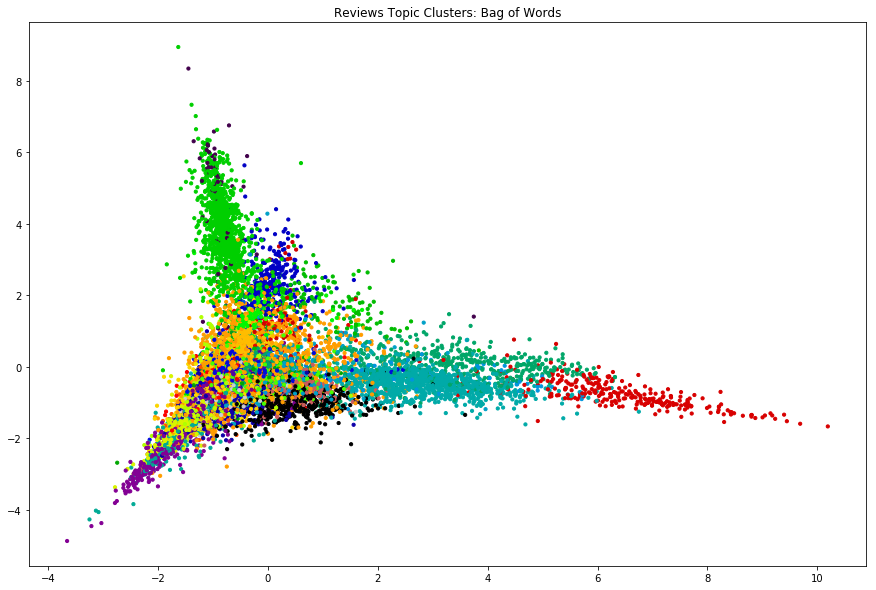

In [24]:
plt.figure(figsize=(15, 10))
plt.title('Reviews Topic Clusters: Bag of Words')
plt.scatter(x_[:, 0], x_[:, 1], 10, y, cmap=cm.nipy_spectral)

### TF-IDF

In [23]:
y_tfidf = KMeans(n_clusters=N_CLUSTERS).fit_predict(x_tfidf)

In [26]:
documents_per_cluster(y_tfidf)

Cluster 0
Optoma EP770 review
Mitsubishi HC5500 review
Pinnacle PCTV NanoStick Ultimate
Epson EMP-TW700 review
Acer P1265 review
Optoma HD28DSE
Viewsonic PJ458D review
InFocus X3 review
Sony VPL-ES3 review
ViewSonic PJ551D review
----------------------------------------

Cluster 1
Hands on: Pioneer SE-Master1 hea
Canon PowerShot G10
DALI Helicon 300 Mk2 review
PS Audio Quintet Power Center re
Vienna Acoustics Haydn Grand rev
Audio Technica ATH-W1000 review
Profigold PROA4801 review
Hands on: Pioneer SE-Master1 hea
Quad Elite Pre / Elite Mono revi
Cambridge Audio S30 review
----------------------------------------

Cluster 2
Canon PowerShot S100 review
Packard Bell IMAX Mini N3600 rev
Kodak EasyShare Z915
Packard Bell EasyNote TX86-JO-04
Packard Bell EasyNote LJ65-AU-05
Nokia Lumia 830 review
Microsoft Lumia 950
Kodak EasyShare C653
Nokia Lumia 610 review
Canon PowerShot S110
----------------------------------------

Cluster 3
Asus G73JH review
Sony VAIO B
Medion Akoya Mini E1312 review

In [37]:
pyLDAvis.enable_notebook()
lda_data = pyLDAvis.gensim.prepare(tfidf_lda_model, tfidf_corpus, dictionary)
pyLDAvis.display(lda_data)

/Users/Omar/miniconda3/envs/data-science/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


In [35]:
x_tfidf_ = PCA(n_components=2).fit_transform(x_tfidf)

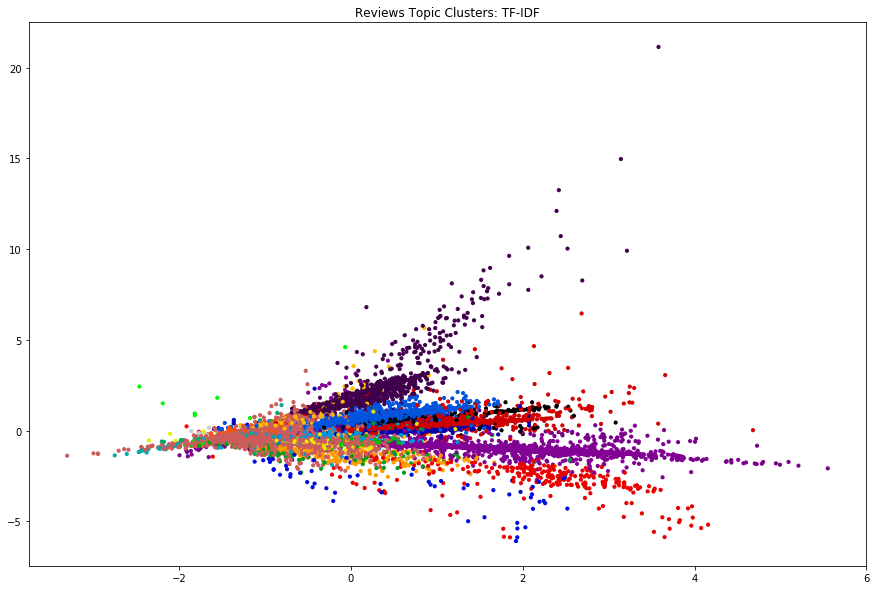

In [36]:
plt.figure(figsize=(15, 10))
plt.title('Reviews Topic Clusters: TF-IDF')
plt.scatter(x_tfidf_[:, 0], x_tfidf_[:, 1], 10, y_tfidf, cmap=cm.nipy_spectral)

## Summary

Pending...